# Reddit-Mining
## Die Ziele im Projekt

Allgemein ist die Aufgabe Texte systematisch aus dem Web zu gewinnen und diese dann auszuwerten.

Wir haben uns zur Aufgabe gemacht durch diverse Reddit-Spiele-Foren (https://reddit.com) zu crawlen und verschiedene Aussagen über die Nutzer und die Spiele der einzelnen Foren zu machen:
    - Wie freundlich sind die Spieler der einzelnen Foren?
    - In welchen Spielen wird am meisten im Web diskutiert?
    - Welche Spieler sind die Freundlichsten, welche Kriterien nehmen den meisten Einfluss?
    
Zusätzlich ist es das Ziel, einen beliebigen Text zu einem der Spiele zuzuordnen.

Zur Datenspeicherung wird nach Aufgabe eine SQL-Lite Datenbank verwendet.   

Wichtig für uns ist Modularität, sodass wir schnell weitere Reddit-Foren hinzufügen können und nach anderen Kriterien suchen können.

# Scraping

Dieser Abschnitt behandelt das Scraping der einzelnen Reddit Pages (Subreddits).

Der Spider benutzt folgende Foren:

In [1]:
start_urls = [
    "https://www.reddit.com/r/DotA2/",
    'https://www.reddit.com/r/GlobalOffensive/',
    'https://www.reddit.com/r/leagueoflegends/',
    'https://www.reddit.com/r/darksouls3/',
    'https://www.reddit.com/r/Witcher3/',
    'https://www.reddit.com/r/Smite/',
    'https://www.reddit.com/r/aoe4/',
    'https://www.reddit.com/r/unrealtournament/',
    'https://www.reddit.com/r/battlefield_one/',
    'https://www.reddit.com/r/FIFA/',
    'https://www.reddit.com/r/WorldofTanks/',
    'https://www.reddit.com/r/FortNiteBR/',
    'https://www.reddit.com/r/PUBATTLEGROUNDS/',
    'https://www.reddit.com/r/starcraft/',
    'https://www.reddit.com/r/RocketLeague/',
    'https://www.reddit.com/r/CallOfDuty/',
    'https://www.reddit.com/r/tf2/',
    'https://www.reddit.com/r/skyrim/',
    'https://www.reddit.com/r/wow/',
    'https://www.reddit.com/r/Guildwars2/',
    'https://www.reddit.com/r/silenthill/',
    'https://www.reddit.com/r/civ/',
    'https://www.reddit.com/r/StreetFighter/',
    'https://www.reddit.com/r/smashbros/',
    'https://www.reddit.com/r/Mario/',
    'https://www.reddit.com/r/Breath_of_the_Wild/',
    'https://www.reddit.com/r/farcry/',
    'https://www.reddit.com/r/pokemon/',
    'https://www.reddit.com/r/Tetris/',
    'https://www.reddit.com/r/heroesofthestorm/',
    'https://www.reddit.com/r/Tekken/',
    'https://www.reddit.com/r/assassinscreed/',
    'https://www.reddit.com/r/mariokart/',
    'https://www.reddit.com/r/granturismo/',
    'https://www.reddit.com/r/forza/',
    'https://www.reddit.com/r/HeroesofNewerth/',
    'https://www.reddit.com/r/Minecraft/',
    'https://www.reddit.com/r/hearthstone/',
    'https://www.reddit.com/r/Terraria/',
    'https://www.reddit.com/r/halo/',
    'https://www.reddit.com/r/GodofWar/',
    'https://www.reddit.com/r/Kirby/',
    'https://www.reddit.com/r/gtaonline/',
    'https://www.reddit.com/r/Wolfenstein/'
]

Für die folgenden Beispiele wird die scrapy basierte Funktion aus Blatt 5 verwendet:

In [2]:
import scrapy
import requests
#copy of sheet 05
def gen_scrapy_response(url):
    # define user agent to simulate interactive user
    user_agent = 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
    req = requests.get(url, headers={ "user-agent": user_agent })
    return scrapy.http.TextResponse(req.url, body=req.text, encoding='utf-8')

Reddit selbst zählt offenbar nur auf dem Frontend seine eigenen Forenbeiträge (Threads) durch. dies geschieht über einen HTTP-GET Paramemter "count".

Diesen kann man somit benutzen um die Tiefe des Spiders in abhängigkeit zur Aktuellen gescrapten Website zu bestimmen. Per default werden immer 25 Threads pro Page angegeben.

In [3]:
import re
response = gen_scrapy_response(start_urls[0])

#sets the depth of the spider, has to be a multiple of 25, if it is not, the next multiple of 25 is used
max_reddit_count = 25

In der Analyse ist uns aufgefallen, dass alle Reddit-Foren zwar unterschiedliche Designs haben, aber immer die selbe Struktur (in Bezug auf den HTML-Baum und die CSS-Klassen) besitzen. Aus diesem Grund können wir das selbe vorgehen auf alle Foren anwenden.

Es gibt drei parse-funktionen:
    - parse: Die Hauptseiten nach Threads parsen, und den "next"-Button finden, um theorethisch durch das gesamte subreddit 
        zu crawlen (reddit zeigt benutzern aber nur die letzten 1.000 Threads eines Subreddits, alle vorherigen sind 
        anscheinend archiviert und auf normalem weg unzugänglich)
    - parse_comments: Geht durch einene einzelnen Thread und erfasst alle Kommentare mit:
        - Erfasser
        - Comment-Karma (abhängig von der Resonanz der User zu diesem Kommentar)
        - Inhalt
        - Thread
        - Spiel
    - parse_user: Die "Homepage" eines einzelnen user parsen um Informationen über:
        - Name
        - Reddit-Geburtstag (Registrierungsdatum)
        - Karma (Die Summe über das gesamte Karma aller Kommentare/Posts)

Im Folgenden wird die grobe Struktur dieser drei Funktionen gezeigt:

### parse

In [4]:
#Find count value to termiante if needed
find_count = re.findall("\?count=([0-9]+)",response.url)
if(len(find_count) > 0):
    count = int(find_count[0])
    if(count >= self.max_reddit_count):
        #now the parse function would return before anything would have been yielded
        print("return")

print("Threads of this Page are:")
for thread in response.css("a.comments::attr(href)").extract():
    #yield response.follow(thread, callback=self.parse_comments)
    print(thread)

next_page = response.css("span.next-button > a::attr(href)").extract_first()

print("The link to the next page is:")
if next_page is not None:
    #yield response.follow(next_page, callback=self.parse,headers={ "user-agent": self.user_agent })
    print(next_page)


Threads of this Page are:
https://www.reddit.com/r/DotA2/comments/8j2ugy/mdl_changsha_survival_guide/
https://www.reddit.com/r/DotA2/comments/8j4pqe/team_secret_confronting_fans_about_their_current/
https://www.reddit.com/r/DotA2/comments/8j4v03/what_i_miss_most_about_tis_feelsbadman/
https://www.reddit.com/r/DotA2/comments/8j5jcn/baby_phoenix_custom_super_nova_boiiii/
https://www.reddit.com/r/DotA2/comments/8j4om0/dota_crashes_when_i_join_a_game_cannot_reconnect/
https://www.reddit.com/r/DotA2/comments/8j37ma/custom_musroom_wd_ulty_baby/
https://www.reddit.com/r/DotA2/comments/8j3cwq/well_i_sure_hope_i_play_badly_next_game_i_guess/
https://www.reddit.com/r/DotA2/comments/8j3ys6/dear_pflax_im_not_a_smurf_that_was_my_dota_plus/
https://www.reddit.com/r/DotA2/comments/8j3ik3/this_snailomancer_set_been_in_workshop_for_2/
https://www.reddit.com/r/DotA2/comments/8j6uo0/ti8_immortal_for_winter_wyvern_absolutely_not/
https://www.reddit.com/r/DotA2/comments/8j71qp/w33_vac_raze/
https://www.red

### parse_comments
Zu beachten ist, das höchstwahrscheinlich in der Ausgabe alle "Scores" gleich 0 sind, dies kann an zwei Punkten liegen:
    - Die Kommentare sind sehr neu, und es hat noch niemand den Kommentar bewertet
    - Manche Subredits erlauben das Bewerten erst 180 Minuten nach Erstellung
    
Um den Output zu minimieren werden nur die ersten 5 Kommentare betrachtet.

Ein weiterer Punkt ist, dass oftmals Unicode-Characters enthalten sind, diese werden einfach entfernt.

In [5]:
response = gen_scrapy_response(response.css("a.comments::attr(href)").extract_first())

title = response.css("a.title::text").extract_first()
game = re.findall("https://www.reddit.com/r/([a-zA-Z0-9_-]+)/",response.url)[0]
for comment in response.css("div.comment")[:5]:
    user = comment.css("div.entry > p.tagline > a.author::text").extract_first()
    user_link = comment.css("div.entry > p.tagline > a.author::attr(href)").extract_first()
    #yield response.follow(userLink, callback=self.parse_user,headers={ "user-agent": self.user_agent })
    print(user_link)

    points = comment.css("span.score::attr(title)").extract_first()
    if(not points):
        points = "0"
    points = int(points)
    full_comment = comment.css("div.usertext-body > div.md")[0]
    text = " ".join(full_comment.css("p::text").extract())
    text = re.sub('\s+',' ',text)
    text = re.sub(r'\\u[a-zA-Z0-9]{4}','',text)
    #yield dict(game=game,score=points,thread=title,user=user,content=text,table_type='comments')
    print(dict(game=game,score=points,thread=title,user=user,content=text))

https://www.reddit.com/user/tohff7
{'game': 'DotA2', 'score': 47, 'thread': 'MDL Changsha Survival Guide', 'user': 'tohff7', 'content': 'Actually, we have to give credit to MDL for having a Bo2 round robin format. Nobody should complain about being cheesed in Bo1s.'}
https://www.reddit.com/user/choseusername2
{'game': 'DotA2', 'score': 24, 'thread': 'MDL Changsha Survival Guide', 'user': 'choseusername2', 'content': 'i think bo2 is even better than bo3'}
https://www.reddit.com/user/freakanime
{'game': 'DotA2', 'score': 17, 'thread': 'MDL Changsha Survival Guide', 'user': 'freakanime', 'content': 'I agree not a fan of BO3 at Epicenter a lot of useless and experimental games.'}
https://www.reddit.com/user/l3ef0re_Time
{'game': 'DotA2', 'score': 57, 'thread': 'MDL Changsha Survival Guide', 'user': 'l3ef0re_Time', 'content': "Two seeds: Secret and LGD, Secret chose a team, LGD chose a team, then the selected teams chose the next teams. The order of the pick was as follow Secret picked Infa

### parse_user

User-Pages sind nicht so konsistent gestaltet. Es gibt zwei verscheidene Designs und Strukturen der Seiten:<br>
Neu: [dluminous](https://www.reddit.com/user/dluminous)<br>
Alt: [babuks2006](https://www.reddit.com/user/babuks2006)<br>
Außerdem gibt es gesperrte user (wird von scrapy gefangen, da Reddit einen HTTP-403 Statuscode sendet) und "+18" accounts ([catsalways](https://www.reddit.com/over18?dest=/user/catsalways)) welche einfach ignoriert werden.

Das nicht alle Benutzer erfasst werden muss in der Analyse berücksichtigt werden.

Zudem soll das "Reddit-alter" gespeichert werden, dafür wird ein String aus dem Dokument mithilfe von _datetime_ verarbeitet.

In [6]:
from datetime import datetime

response = gen_scrapy_response("https://www.reddit.com/user/dluminous")
#response = gen_scrapy_response("https://www.reddit.com/user/babuks2006")

findname = response.css("a.ProfileSidebar__nameTitleLink::text").extract_first()
if(findname):
    name = re.findall("u/(.*)",findname)[0]
    birthday = response.css("div.UserSpecialsListSidebar > div > ul > li > span.UserSpecialsListSidebar__date::text").extract_first()
    birthday = str(datetime.strptime(birthday, '%B %d, %Y'))
    karma = int(re.sub(r"[., ]|Karma","",str(response.css("div.ProfileSidebar__counters > span >span::text").extract_first())))
    #yield dict(name=name,birthday=birthday,karma = karma,table_type='users')
    print(dict(name=name,birthday=birthday,karma = karma))
else:
    name = response.css("div.titlebox > h1::text").extract_first()
    if( not name):
        #return #ignore this user, this can occur due to +18 rating of the user
        print("return")
    birthday = response.css("span.age > time::attr(datetime)").extract_first()
    birthday = str(datetime.strptime(birthday, '%Y-%m-%dT%H:%M:%S+00:00'))
    karma_post = int(re.sub(r",","",response.css("span.karma::text").extract_first()))
    karma_comment = int(re.sub(r",","",response.css("span.comment-karma::text").extract_first()))
    #yield dict(name=name,birthday=birthday,karma = karma_post + karma_comment,table_type='users')
    print(dict(name=name,birthday=birthday,karma = karma_post + karma_comment))

{'name': 'dluminous', 'birthday': '2013-02-21 00:00:00', 'karma': 47741}


Alle Daten wurden über den Spider in .jl Files gespeichert, diese sind für den Nächsten abstand erforderlich.

## Datenbank

Für die weitere Analyse werden die Daten in einer SQL-Lite Datenbank gespeichert.

Hierfür werden zunächst die Dateien _users.jl_ und _comments.jl_ ausgelesen:

In [7]:
import json

users_file = 'resources/users.jl'

users = []
with open(users_file) as file:
    for line in file:
        item = json.loads(line)
        users.append(item)
        
comments_file = 'resources/comments.jl'

comments = []
with open(comments_file) as file:
    for line in file:
        item = json.loads(line)
        comments.append(item)

Nun sollten die Daten in python benutzbar sein:

In [8]:
print(comments[0])
print(len(comments))
print(users[0])
print(len(users))

{'game': 'darksouls3', 'score': 23, 'thread': 'A fun little interaction', 'user': 'bioticeye', 'content': 'Gank spank them with diplomacy. I love it!'}
86640
{'name': 'TitMcgee8358', 'birthday': '2017-12-21 00:00:00', 'karma': 1602}
41575


Nun können die Daten in eine Sqlite Datenbank übernommen werden:

In [9]:
import sqlite3

database="resources/reddit.sqlite"
#Hilfsfunktion von Blatt 06
def sql_execute(database, sql):
    with sqlite3.connect(database) as con:
        cur = con.cursor()
        # damit man sieht, was passiert
        print("Executing in %s:\n%s" % (database, sql))
        cur.execute(sql)
        if cur.rowcount >= 0:
            print(cur.rowcount, " rows affected.")
        print("--> OK")

In [10]:
#clearing Database if needed:
if(1):
    sql_execute(database,"DROP TABLE users");
    sql_execute(database,"DROP TABLE comments");
    

#creating Tables:
sql_execute(database,"CREATE TABLE IF NOT EXISTS users (name TEXT,birthday TEXT,karma INTEGER)");
sql_execute(database,"CREATE TABLE IF NOT EXISTS comments (game TEXT,score Integer,thread TEXT,content TEXT,user TEXT)");

#copying data reused function from sheet 06:
with sqlite3.connect(database) as con:
    cur = con.cursor()

    cnt = 0
    for user in users:

        sql = "INSERT INTO users (name,birthday,karma) VALUES ('%s','%s',%i)" % (user['name'],user['birthday'],user['karma'])
        try:
            cur.execute(sql)
            cnt += 1
        except Exception as e:
            print("EXCEPTION: %s " % e)
            print(sql)
            print(user)
            raise
    
    print("%d records inserted into %s." % (cnt, "users"))
    cnt = 0
    for comment in comments:

        if(len(comment['content']) > 0):
            sql = "INSERT INTO comments (game,thread,content,score,user) VALUES ('%s','%s','%s',%i,'%s')" %\
            (comment['game'],re.sub("'","''",comment['thread']),re.sub("'","''",comment['content']),comment['score'],comment['user'])
            try:
                cur.execute(sql)
                cnt += 1
            except Exception as e:
                print("EXCEPTION: %s " % e)
                print(sql)
                print(user)
                raise

    print("%d records inserted into %s." % (cnt, "comments"))
    

Executing in resources/reddit.sqlite:
DROP TABLE users
--> OK
Executing in resources/reddit.sqlite:
DROP TABLE comments
--> OK
Executing in resources/reddit.sqlite:
CREATE TABLE IF NOT EXISTS users (name TEXT,birthday TEXT,karma INTEGER)
--> OK
Executing in resources/reddit.sqlite:
CREATE TABLE IF NOT EXISTS comments (game TEXT,score Integer,thread TEXT,content TEXT,user TEXT)
--> OK
41575 records inserted into users.
85457 records inserted into comments.


## Exploration
Nachdem alle Daten in die Datenkbank geschrieben wurden kann nun versucht werden, ein paar erste Erfahrungen mit den Daten zu machen.

In [11]:
%load_ext sql
%sql sqlite:///resources/reddit.sqlite

C:\Users\matth\Anaconda3\lib\site-packages\IPython\config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
C:\Users\matth\Anaconda3\lib\site-packages\sql\magic.py:4: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Bool, Int, Unicode


'Connected: None@resources/reddit.sqlite'

Beispielsweise könnte man versuchen die beliebtesten Kommentare zu finden:

In [12]:
%sql SELECT * FROM comments ORDER BY score DESC LIMIT 3

Done.


game,score,thread,content,user
FortNiteBR,8428,Thats the reason why we fail building sometimes?,"Holy fuck, thank you. I never took the time to slowly look at it but the amount of times this has fucked me up is too damn high",hoeoclock
FortNiteBR,4321,Weapon Description Sheet,Mini shields: Only found after drinking a big shield,CT12z
GlobalOffensive,4216,FaceIt set to sign $3.2m exclusivity deal with Snapchat,"We may lose 95 or 99 percent of our audience, but then we grow our gaming room and buy new pcs for fortnite",Faceit_Mikey


Order die unbeliebtesten:

In [13]:
%sql SELECT * FROM comments ORDER BY score ASC LIMIT 3

Done.


game,score,thread,content,user
wow,-524,Nice one Blizzard !,"So fuck the lore, fuck the atmosphere. Let's make everything a meme because that gets you publicity on the internet. They might as well remove ""Warcraft"" from the name.",donkeyponkey
RocketLeague,-295,An RLCS player didn't communicate during their RLCS promotion matches because he found out he was being kicked,Have you seen your flair?,BeanbagRL
leagueoflegends,-159,"Kira: ""Our chances against Kingzone would be 50:50 - we either win or we lose!",Its an overused joke maybe that is the cause.,IPayForPixels


An diesem Punkt könnte man bereits vergleichen wie hoch der durchschnittliche Karma-Score eines Kommentar eines Forum ist.

Zur veranschaulichung wird _matplotlib_ verwendet.

In [14]:
average_scores = %sql SELECT game,AVG(score) as avg_score FROM comments GROUP BY game ORDER BY avg_score DESC

Done.


In [15]:
import matplotlib.pyplot as plt
import numpy as np
#Function from sheet06, modified
def txa_plot(list_of_tuples, columns=('Iterator', 'Wert'), title=None,dx = .5,dy=.25): 

    labels = [t[0] for t in list_of_tuples]
    values = [t[1] for t in list_of_tuples]
    dummy_pos = np.arange(len(labels))
    
    # Erstellung des Balkendiagramms
    fig=plt.figure(figsize=(18, 10))
    plt.bar(dummy_pos, values)
    plt.xticks(dummy_pos, labels,  rotation="vertical", fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel(columns[0], fontsize=20)
    plt.ylabel(columns[1], fontsize=20)
    #displays the value of a bar above the bar
    for i,v in enumerate(values):
        plt.text(i - dx,v + dy,str("%.1f" % v),color="black",fontsize=10)
    if title: 
        plt.title(title, fontsize=20)

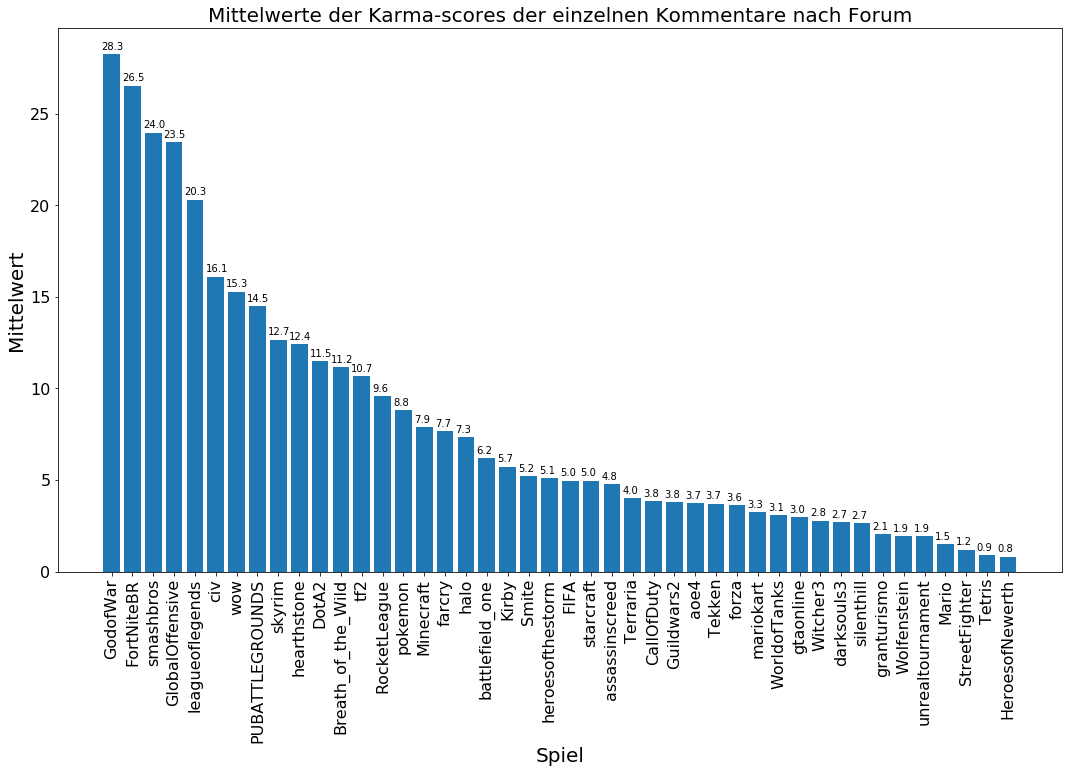

In [16]:
txa_plot(average_scores,('Spiel','Mittelwert'),'Mittelwerte der Karma-scores der einzelnen Kommentare nach Forum')

Auffällig ist, das alte Spiele, und Spiele mit kleinen Fangemeinden schlechter Abschneiden. Man könnte versuchen die Relevanz zu erhöhen in dem man dies mit der Aktivität in den Foren gewichtet.

Hierfür wäre es interessant zu wissen, wie viele Kommentare im Schnitt pro Thread erfasst wurden, zu beachten ist hierbei, dass zu tiefe Verschachtelungen von Kommentaren und antworten nicht mitgescrapt sind, da diese nur über Javascript aufruf bar sind.

Zudem sollte man erwähnen, dass nicht nur kommentierende User existieren, es wird also die Annahme getroffen, dass die Kommentaranzahl linear propertional zur Gesamtaktivität ist.

In [17]:
average_comments = %sql SELECT game,AVG(count) as avg FROM (SELECT COUNT(*) as count,game FROM comments GROUP BY thread) GROUP BY game ORDER BY avg DESC

Done.


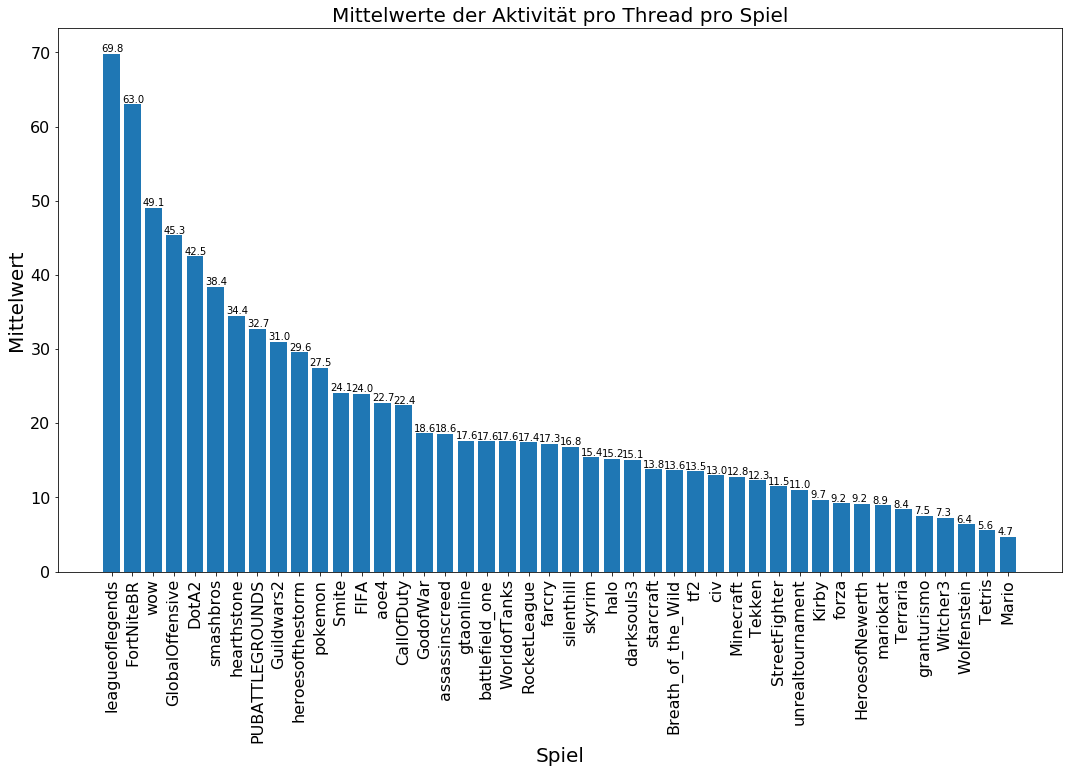

In [18]:
txa_plot(average_comments,('Spiel','Mittelwert'),"Mittelwerte der Aktivität pro Thread pro Spiel")

In [19]:
average_score_by_activity = %sql SELECT avgs.game,avg_score/avg_count as avg,avg_score,avg_count from (SELECT game,AVG(score) as avg_score FROM comments GROUP BY game) as avgs JOIN (SELECT game,AVG(count) as avg_count FROM (SELECT COUNT(*) as count,game FROM comments GROUP BY thread) GROUP BY game) as avgc  ON avgc.game = avgs.game ORDER BY avg DESC

Done.


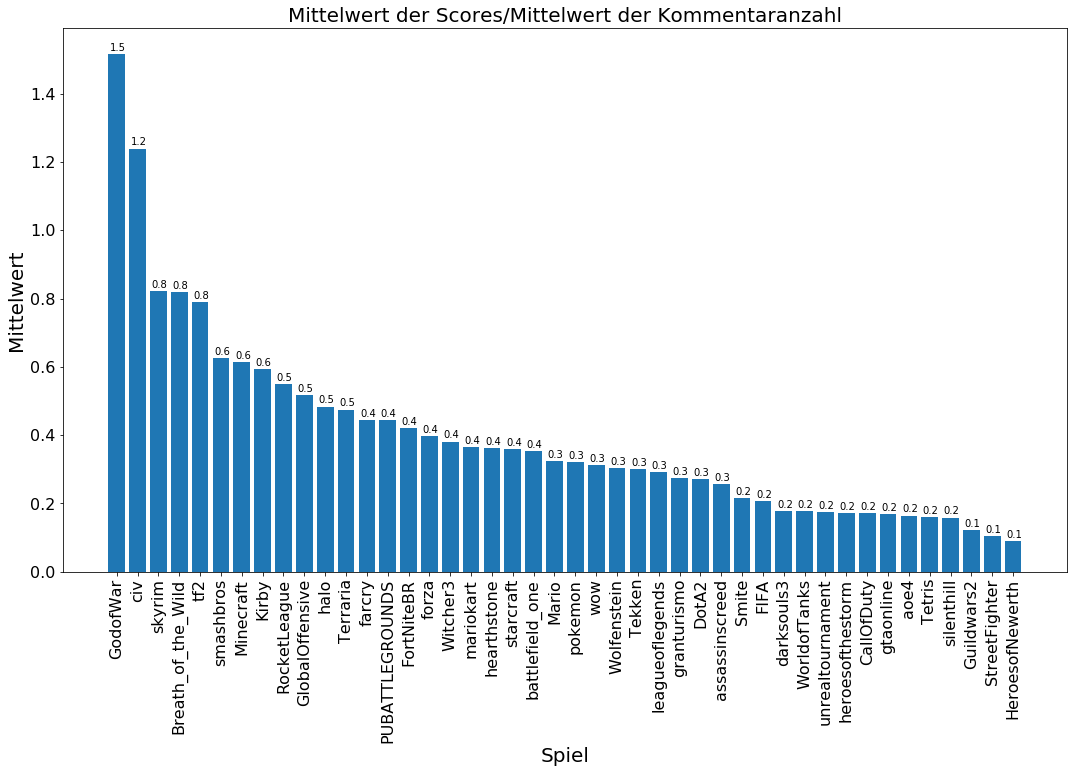

In [20]:
txa_plot(average_score_by_activity,('Spiel','Mittelwert'),"Mittelwert der Scores/Mittelwert der Kommentaranzahl",dx=.33,dy=0.01)

In [21]:
average_score_by_activity

game,avg,avg_score,avg_count
GodofWar,1.5168890650460212,28.279146141215108,18.642857142857142
civ,1.2392793032378167,16.110630942091618,13.0
skyrim,0.8205988570565542,12.657973174366617,15.425287356321839
Breath_of_the_Wild,0.8187459659276441,11.174021648626145,13.647727272727273
tf2,0.7885955480195614,10.663183279742766,13.521739130434783
smashbros,0.6251041746879537,23.97818078775857,38.358695652173914
Minecraft,0.6149355542335911,7.878861788617886,12.8125
Kirby,0.5929576924552185,5.731924360400445,9.666666666666666
RocketLeague,0.5487849405655403,9.573248407643312,17.444444444444443
GlobalOffensive,0.5178650842067548,23.471156056079064,45.322916666666664


Als letztes wäre noch interessant zu wissen, wie lang die einzelnen Kommentare im Schnitt sind. Eventuell haben länge Kommentare im Schnitt einen höheren Score. Es wird versucht dies herauszufinden.

In [22]:
comments = %sql select content,score from comments

Done.


In [23]:
comments_words_score = [(len(re.split(r' ',x[0])),x[1]) for x in comments] # wörter
#comments_words_score = [(len(x[0]),x[1]) for x in comments] #Zeichen
#comments_words_score = [(len(re.split(r' ',x[0])),x[1]) for x in comments if x[1]<1000 and x[1] > 0] # wörter, etwas geglättet

Text(0.5,1,'Scores nach Kommentarlänge')

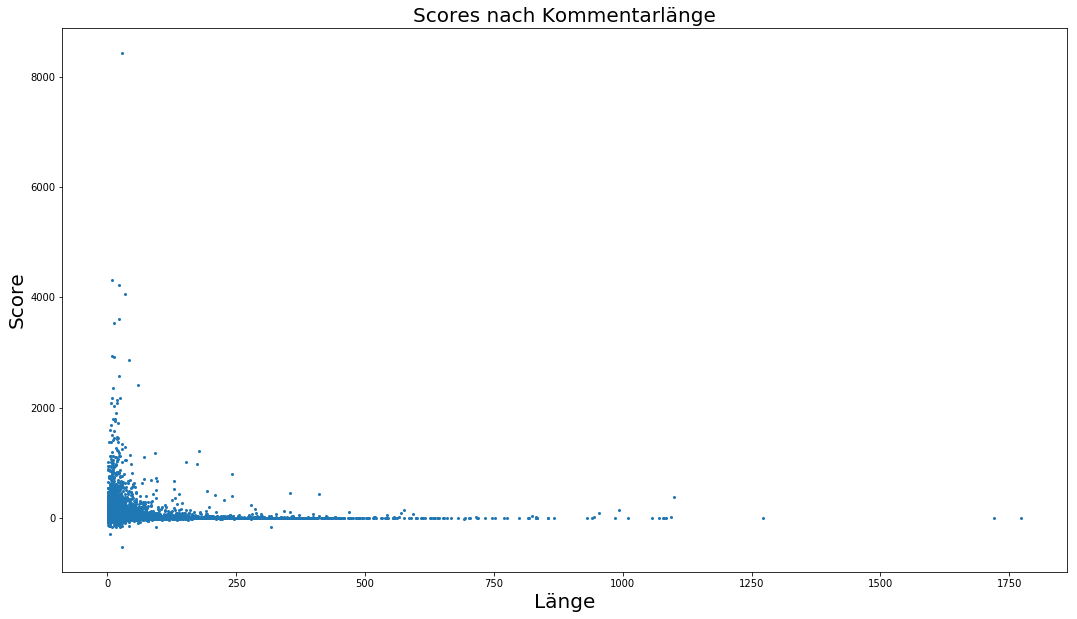

In [24]:
fig = plt.figure(figsize=(18, 10))
x = [t[0] for t in comments_words_score]
y = [t[1] for t in comments_words_score]
plt.plot(x,y,linestyle='none',marker='.',markersize=4)
plt.xlabel("Länge", fontsize=20)
plt.ylabel("Score", fontsize=20)
plt.title("Scores nach Kommentarlänge",fontsize=20)

Als Maß für den Zusammenhang könnte man Pearson hernehmen (gilt nur bei linearem Zusammenhang).

In [25]:
def calc_pearson(list_of_coordinates):
    n = len(list_of_coordinates)
    #mean values
    mx = 0.0
    my = 0.0
    for el in list_of_coordinates:
        mx += el[0]
        my += el[1]
    mx /= n
    my /= n
    
    #calculate variances and covariance
    varx = 0.0
    vary = 0.0
    cov = 0.0
    for el in list_of_coordinates:
        cov += (el[0]-mx)*(el[1]-my)
        varx += (el[0]-mx)**2
        vary += (el[1]-my)**2
    cov /=(n-1)
    varx /=(n-1)
    vary /=(n-1)
    sx = varx**(1/2)
    sy = vary**(1/2)
    pearson = cov/(sx*sy)
    return pearson

In [26]:
print(calc_pearson(comments_words_score))

-0.009855281498479508


Offenbar besteht jedoch kein (linearer) Zusammenhang zwischen Länge eines Kommentar und dessen Score. Grund dafür könnten die kurzen Kommentare mit extrem hohen Scores und die Langen kommentare mit extrem niedrigen sein. Auf einem Fachforum wie http://stackoverflow.com wäre dieses Ergebnis eventuell anders.

Noch eine Interessante Analyse wäre das Vorkommen von Smilies und emoticons in den Texten. Es werden nur Smilies aus normalen ASCII-Zeichen betrachtet.

In [27]:
import pandas
from collections import Counter
#extracts list of ("smilie",counter) for given text
def count_normalized_smilies (text):
    smilies = re.findall(r"[:=]-?P|[:=]-?\(|[:=]-?\)|[:=]-?D|[:=]-?O|[:=]-?\*|;-?\)|[oO]\.[oO]|\*\.\*",text) #content column
    normalized_smilies = []
    for smilie in smilies:
        normalized_smilies.append(re.sub("=",":",re.sub("-","",smilie)).upper())
    return Counter(normalized_smilies).most_common()

with sqlite3.connect(database) as con:
    smilie_df = pandas.read_sql_query("SELECT game, group_concat(content,' ') as text FROM comments GROUP BY game ORDER BY game",con)

smilie_df["smilie_count"] = smilie_df.text.map(count_normalized_smilies)

# format dataframe for plot function:
smilies_plotable = []

#agg_df.head(10)
for index, row in smilie_df.iterrows():
    game = row['game']
    c = row['smilie_count']
    for k in c:
        smilies_plotable.append((game,k[0],k[1]))           
#your code here

smilies_plotable_df = pandas.DataFrame.from_records(smilies_plotable, columns=['Spiel', 'Smilie', 'Anzahl'])
smilies_plotable_df = smilies_plotable_df.pivot(index=smilies_plotable_df.columns[0], columns=smilies_plotable_df.columns[1], values=smilies_plotable_df.columns[2])

In [28]:
smilies_plotable_df.head()

Smilie,:(,:),:*,:D,:O,:P,;),O.O
Spiel,,,,,,,,
Breath_of_the_Wild,4.0,23.0,NaN,2.0,1.0,1.0,8.0,NaN
CallOfDuty,9.0,17.0,NaN,4.0,NaN,3.0,2.0,NaN
DotA2,32.0,38.0,NaN,19.0,1.0,4.0,6.0,NaN
FIFA,8.0,30.0,NaN,16.0,NaN,1.0,10.0,NaN
FortNiteBR,30.0,52.0,NaN,13.0,1.0,6.0,13.0,1.0


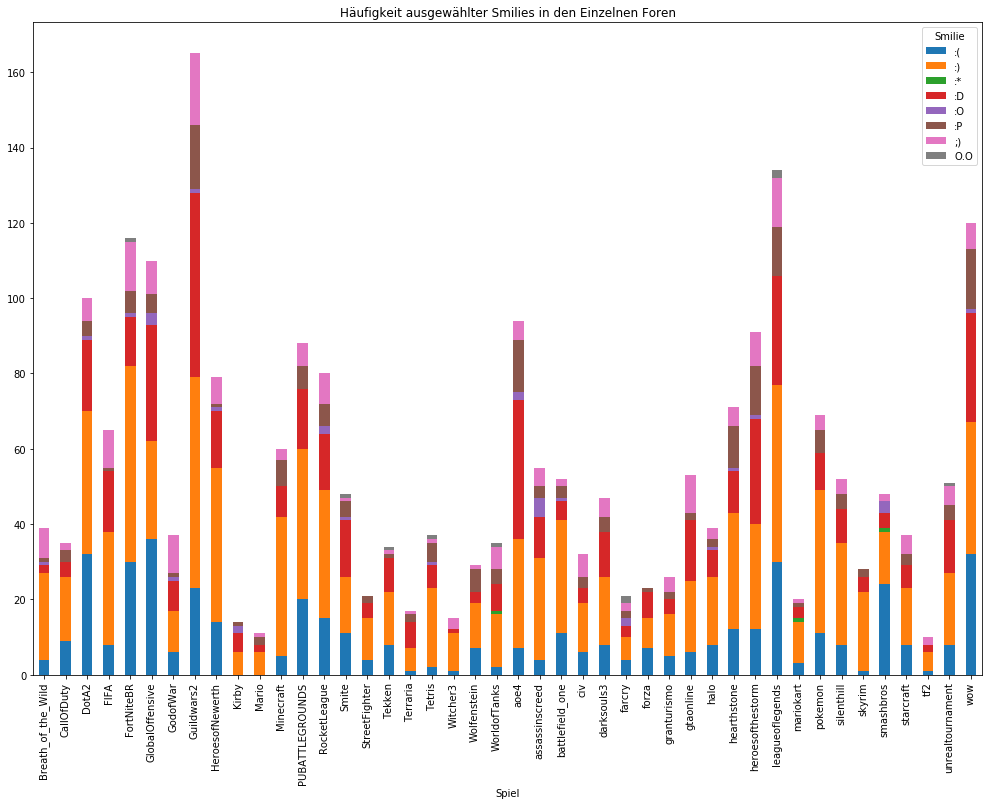

In [29]:
smilies_plotable_df.plot(kind="bar",stacked=True,figsize=(17,12),title="Häufigkeit ausgewählter Smilies in den Einzelnen Foren")

Zuletzt könnte man noch erkennen wie sich die Kommentare über die Spiel verteilen. Um das ganze einfach zu plotten wird hierfür schon ein Dataframe bentuzt.

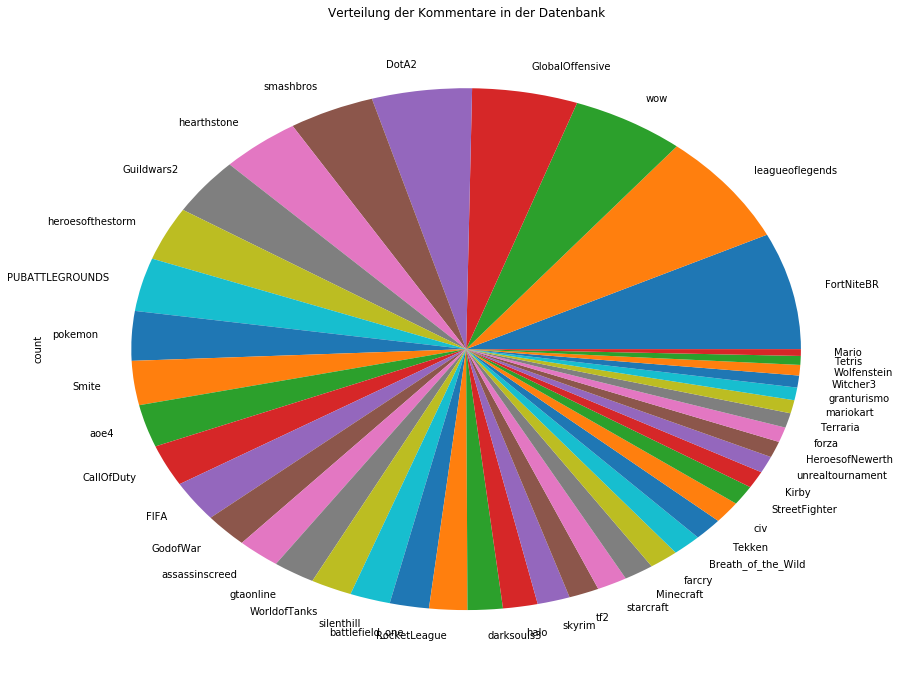

In [30]:
with sqlite3.connect(database) as con:
    comments_per_category = pandas.read_sql_query("SELECT COUNT(*) as count, game FROM comments GROUP BY game ORDER BY count DESC", con)
comments_per_category.plot.pie(labels=comments_per_category.game,y="count",figsize=(15,12),legend=False,title="Verteilung der Kommentare in der Datenbank")
#TODO integrate ',title.font'

## Klassifizierung

Für die Klassifizierung müssen zunächst die Daten aufbereitet werden. Hierfür werden zunächst alle Kommentare in ein dataframe gezogen.

In [31]:
with sqlite3.connect(database) as con:
    comments_df = pandas.read_sql_query("SELECT * FROM comments", con)
comments_df[:5]

,game,score,thread,content,user
0,darksouls3,23,A fun little interaction,Gank spank them with diplomacy. I love it!,bioticeye
1,darksouls3,10,A fun little interaction,Meanwhile Im just minding my own business on a...,Error_X
2,darksouls3,3,A fun little interaction,Should have left and dropped your summon sign ...,saviourQQ
3,darksouls3,20,The souls community is the best.,Wait until DS1 drops again. We’ll all hate eac...,Ashen-Knight
4,darksouls3,5,The souls community is the best.,What r u casul? :P I guess we'll have to wait ...,Izzcariot


Dann wird eine eigene Pipeline definiert.

In [32]:
import nltk
import string
#sheet 06
punctuation = set(string.punctuation) | {'``', "''", '–',"'","’",'\\','/','(',')',';','%','?','!','_',':'}

def remove_punctuation(tokens):
    return [t for t in tokens if t not in punctuation]

stopwords = set(nltk.corpus.stopwords.words('english'))
custom_stopwords = {"r","u","im","get", '\'s', '\'m'}
stopwords = stopwords.union(custom_stopwords)

def remove_stopwords(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

def remove_numbers(tokens):
    return [t for t in tokens if not re.findall(r'[0-9]+',t)]

def preprocess(text):
    text = nltk.word_tokenize(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    return text

In [33]:
processed_comments_df = comments_df[['game', 'score','thread','user','content']].copy()

processed_comments_df["processed_content"] = comments_df["content"].map(preprocess)

In [34]:
all_words_list = []
for comment_words in processed_comments_df.processed_content:
    all_words_list += comment_words
    


## Sentiment Analysis

Für die Sentiment Analyse steht durch das NLTK bereits VADER zur verfügung, welches bereits in der Lage ist über sein Wörterbuch eine regelbasierte Einstufung vorzunehmen.

In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

C:\Users\matth\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Zunächst wird eine Datenserie erzeugt, die sich aus der Abbildung der Inhaltsspalte durch die polarity_scores-Methode des SentimentIntensityAnalyzers ergibt.

In [36]:
intensity_analyzer = SentimentIntensityAnalyzer()

processed_with_sent = processed_comments_df.copy()
sentiment_series = processed_with_sent["content"].map(lambda text: intensity_analyzer.polarity_scores(text))

Der Inhalt dieser Datenserie hat mit einem Dictionary pro Zeile noch ein recht unvorteilhaftes Format,
wenn wir später komfortabel und schnell auf die Werte zugreifen wollen.
Aufgrund dessen wird jeder Wert des Dictionaries nun einer Spalte des Dataframes zugeordnet.

In [37]:
processed_with_sent["sent_neg"] = sentiment_series.map(lambda x: x["neg"])
processed_with_sent["sent_neu"] = sentiment_series.map(lambda x: x["neu"])
processed_with_sent["sent_pos"] = sentiment_series.map(lambda x: x["pos"])
processed_with_sent["sent_comp"] = sentiment_series.map(lambda x: x["compound"])

processed_with_sent.head()

,game,score,thread,user,content,processed_content,sent_neg,sent_neu,sent_pos,sent_comp
0,darksouls3,23,A fun little interaction,bioticeye,Gank spank them with diplomacy. I love it!,"[Gank, spank, diplomacy, love]",0.00,0.572,0.428,0.6696
1,darksouls3,10,A fun little interaction,Error_X,Meanwhile Im just minding my own business on a...,"[Meanwhile, minding, business, chilled, first,...",0.00,1.000,0.000,0.0000
2,darksouls3,3,A fun little interaction,saviourQQ,Should have left and dropped your summon sign ...,"[left, dropped, summon, sign, boss, door]",0.00,1.000,0.000,0.0000
3,darksouls3,20,The souls community is the best.,Ashen-Knight,Wait until DS1 drops again. We’ll all hate eac...,"[Wait, drops, hate]",0.27,0.730,0.000,-0.5719
4,darksouls3,5,The souls community is the best.,Izzcariot,What r u casul? :P I guess we'll have to wait ...,"[casul, P, guess, 'll, wait, see, that\^^]",0.00,0.778,0.222,0.4824


Nun sind die Voraussetzungen geschaffen, um effizient auf den Daten arbeiten zu können.

### Durchschnittliche Scores

Eine simple Auswertung ist beispielsweise das Bilden der durchschnittlichen Bewertungen der Sentiment-Analyse pro Spiel

In [38]:
sent_mean = {}
sent_mean["neg"] = processed_with_sent.groupby(['game'])["sent_neg"].mean().sort_values(ascending=False)
sent_mean["neu"] = processed_with_sent.groupby(['game'])["sent_neu"].mean().sort_values(ascending=False)
sent_mean["pos"] = processed_with_sent.groupby(['game'])["sent_pos"].mean().sort_values(ascending=False)
sent_mean["comp"] = processed_with_sent.groupby(['game'])["sent_comp"].mean().sort_values(ascending=False)
sent_mean["steadiness"] = (sent_mean["neg"] + sent_mean["pos"]).sort_values(ascending=False)


### Negativstes Subreddit

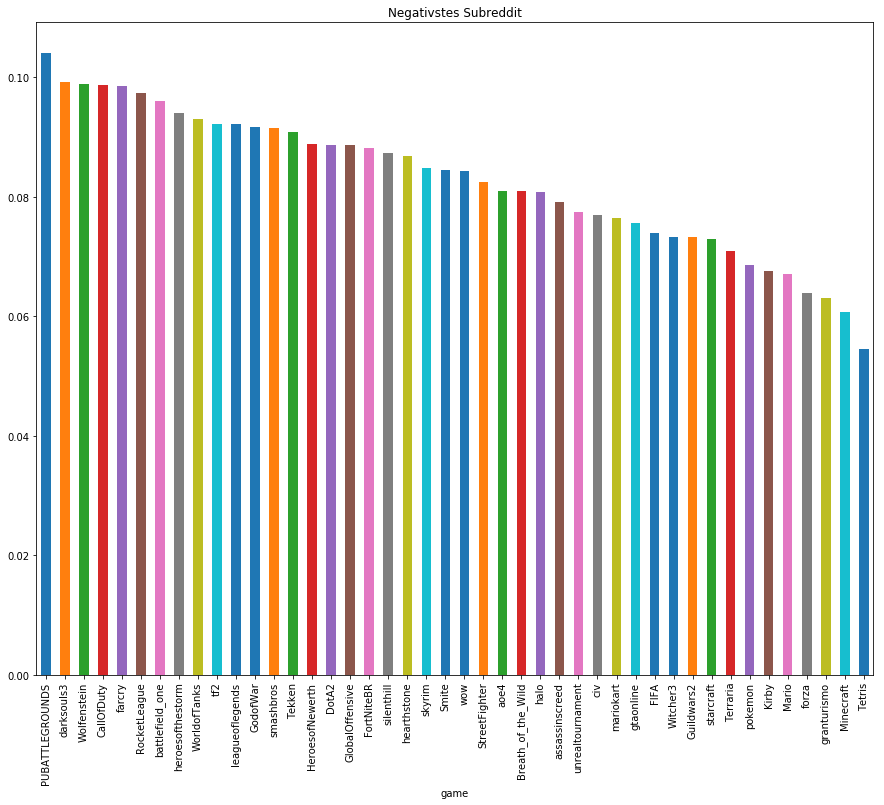

In [39]:
sent_mean["neg"].plot(kind="bar", figsize=(15,12), title="Negativstes Subreddit")

### Positivstes Subreddit

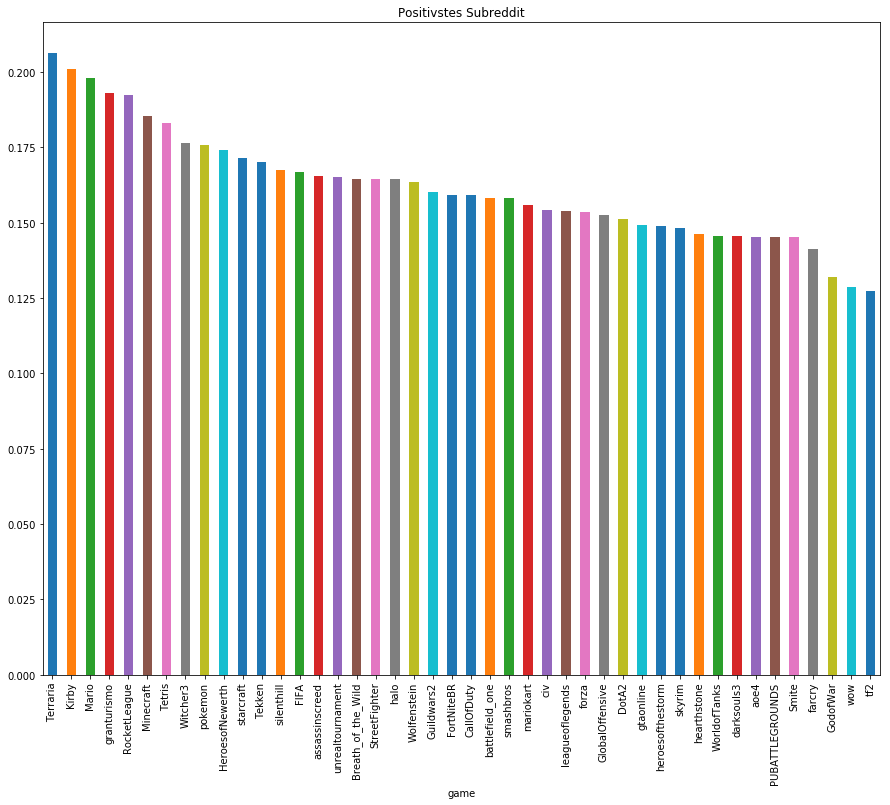

In [40]:
sent_mean["pos"].plot(kind="bar", figsize=(15,12), title="Positivstes Subreddit")

### Subrredit mit der besten durchschnittlichen Gesamtwertung

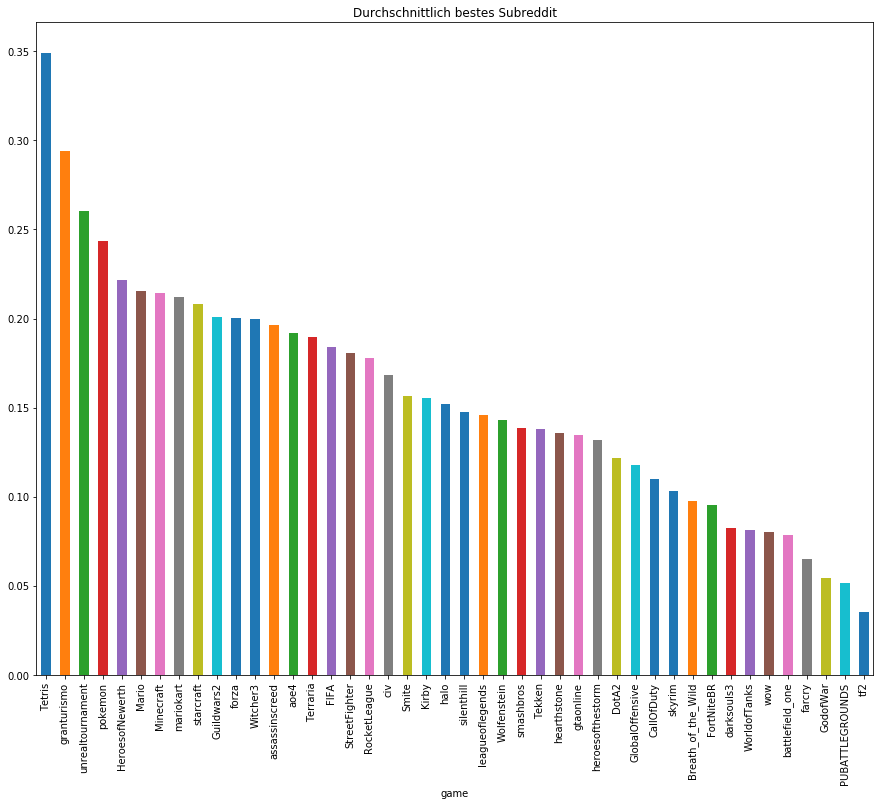

In [41]:
sent_mean["comp"].plot(kind="bar", figsize=(15,12), title="Durchschnittlich bestes Subreddit")

### Subreddit mit dem größten Abstand zwischen positivem und negativem Durschnitt

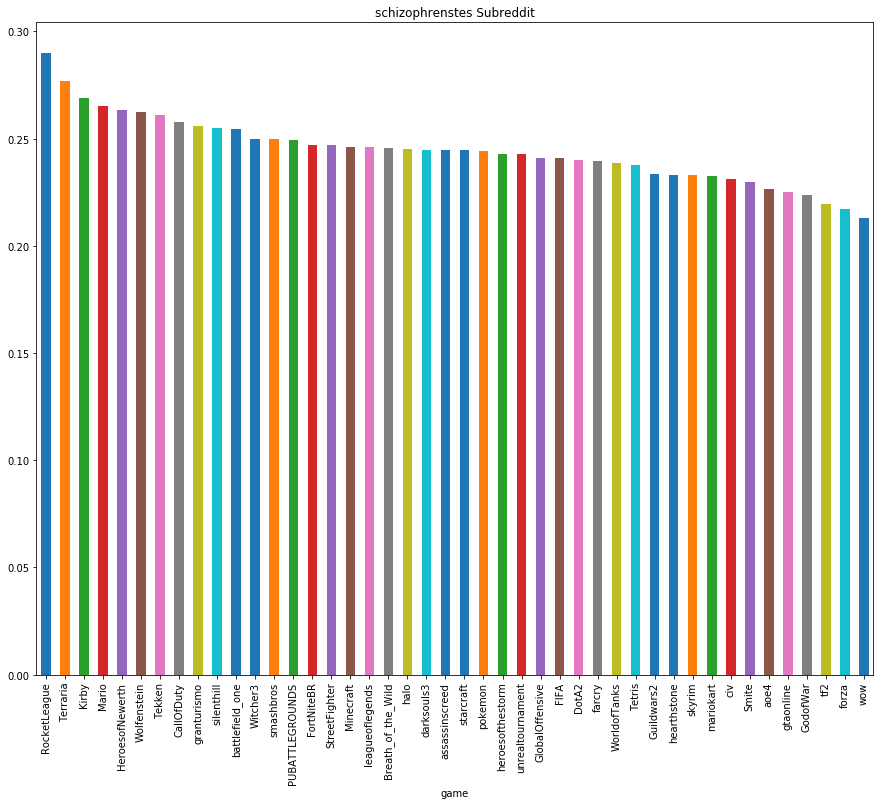

In [42]:
sent_mean["steadiness"].plot(kind="bar", figsize=(15,12), title="schizophrenstes Subreddit")